In [18]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import cv2
import time
from tqdm import tqdm_notebook as tqdm
from PIL import Image   
import torchvision
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)




cuda


In [ ]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

In [2]:
train_dir = 'Data/train'
test_dir = 'Data/test1'


train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in Data/train is 25000
Number of images in Data/test1 is 12500


In [4]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

Data/train\cat.0.jpg


In [5]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

In [6]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [7]:
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

In [8]:
train.__getitem__(0)

(tensor([[[0.8118, 0.8392, 0.8706,  ..., 0.9725, 0.9686, 0.9569],
          [0.8118, 0.8392, 0.8706,  ..., 0.9765, 0.9686, 0.9608],
          [0.8157, 0.8431, 0.8706,  ..., 0.9725, 0.9686, 0.9647],
          ...,
          [0.6431, 0.6549, 0.6706,  ..., 0.0118, 0.0157, 0.0118],
          [0.6275, 0.6392, 0.6588,  ..., 0.0118, 0.0118, 0.0118],
          [0.6078, 0.6275, 0.6471,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.6588, 0.6824, 0.7059,  ..., 0.8471, 0.8235, 0.8000],
          [0.6588, 0.6824, 0.7059,  ..., 0.8549, 0.8353, 0.8118],
          [0.6549, 0.6784, 0.7020,  ..., 0.8549, 0.8471, 0.8314],
          ...,
          [0.5098, 0.5216, 0.5294,  ..., 0.0157, 0.0196, 0.0157],
          [0.4941, 0.5059, 0.5176,  ..., 0.0157, 0.0157, 0.0118],
          [0.4863, 0.4980, 0.5098,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.3569, 0.3804, 0.4000,  ..., 0.5490, 0.5098, 0.4824],
          [0.3569, 0.3804, 0.4000,  ..., 0.5608, 0.5333, 0.4980],
          [0.3608, 0.3843, 0.4000,  ...,

In [9]:
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


In [10]:
train, val = torch.utils.data.random_split(train,[20000,5000]) 

In [11]:
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

c:\Users\saeid\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\saeid\anaconda3\envs\pytorch\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<AxesSubplot:ylabel='count'>

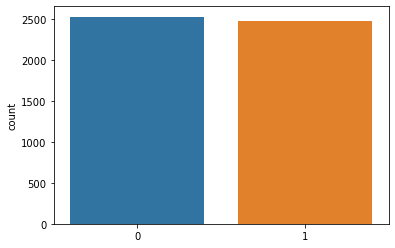

In [12]:
import seaborn as sns

sns.countplot(val_set_class_count)

In [13]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

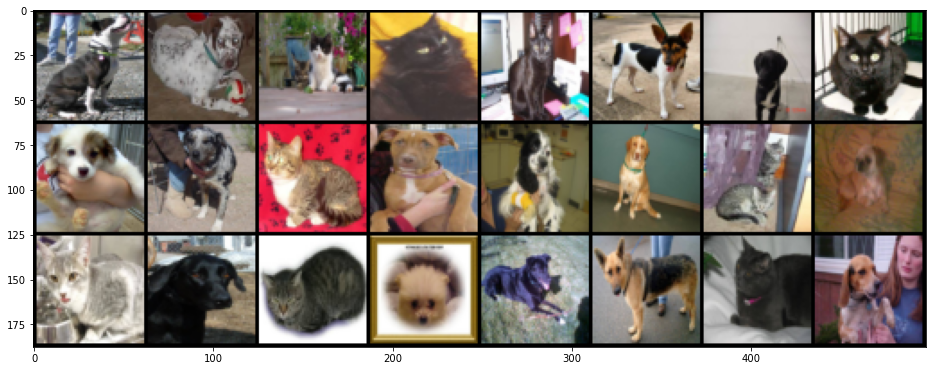

In [14]:
samples, labels = next(iter(train_dataset)) # Getting a batch of samples and labels
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))


In [15]:
samples.shape

torch.Size([32, 3, 60, 60])

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [19]:
model = Classifier()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

In [21]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 
            

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

C:\Users\saeid\AppData\Local\Temp\ipykernel_28788\2195970425.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

c:\Users\saeid\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1 Training Accuracy = 0.6029
Epoch 1 Training Loss = 21.07260347290039
Epoch 1 Validation Accuracy = 0.6686
Epoch 1 Validation Loss = 19.6527097847811


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6932
Epoch 2 Training Loss = 19.139298205566405
Epoch 2 Validation Accuracy = 0.7114
Epoch 2 Validation Loss = 18.34598777552319


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.73005
Epoch 3 Training Loss = 18.102143966674806
Epoch 3 Validation Accuracy = 0.745
Epoch 3 Validation Loss = 17.506408521324207


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.75765
Epoch 4 Training Loss = 17.39061615600586
Epoch 4 Validation Accuracy = 0.7436
Epoch 4 Validation Loss = 17.622760678552517


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7693
Epoch 5 Training Loss = 16.932386457824705
Epoch 5 Validation Accuracy = 0.76
Epoch 5 Validation Loss = 17.046058244765945


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7848
Epoch 6 Training Loss = 16.564869116210936
Epoch 6 Validation Accuracy = 0.7738
Epoch 6 Validation Loss = 16.688497017902932


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.7974
Epoch 7 Training Loss = 16.145546310424805
Epoch 7 Validation Accuracy = 0.7794
Epoch 7 Validation Loss = 16.625206831913843


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8088
Epoch 8 Training Loss = 15.81230633392334
Epoch 8 Validation Accuracy = 0.7946
Epoch 8 Validation Loss = 16.178510428993565


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.82425
Epoch 9 Training Loss = 15.443013745117188
Epoch 9 Validation Accuracy = 0.7862
Epoch 9 Validation Loss = 16.339084692062087


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.83515
Epoch 10 Training Loss = 15.088658695983886
Epoch 10 Validation Accuracy = 0.7868
Epoch 10 Validation Loss = 16.441837966821755


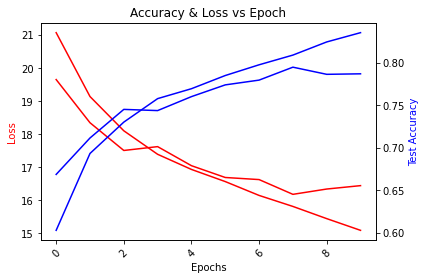

In [22]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [23]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

In [24]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = Classifier()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
image_path = 'Data/test1/5.jpg'
image = Image.open(image_path).convert('RGB')
image = transformations(image)
image = image.unsqueeze(0)  # Add a batch dimension (1, 3, 60, 60)


image = image.to(device)
model.eval()

with torch.no_grad():

    output = model(image)
    _, pred = torch.max(output, 1)
    predicted_class = pred.item()

answer_prediction = {1 : "dog", 0 : "cat"}    
print(predicted_class)
print(f'Predicted class: {answer_prediction[predicted_class]}')


0
Predicted class: cat


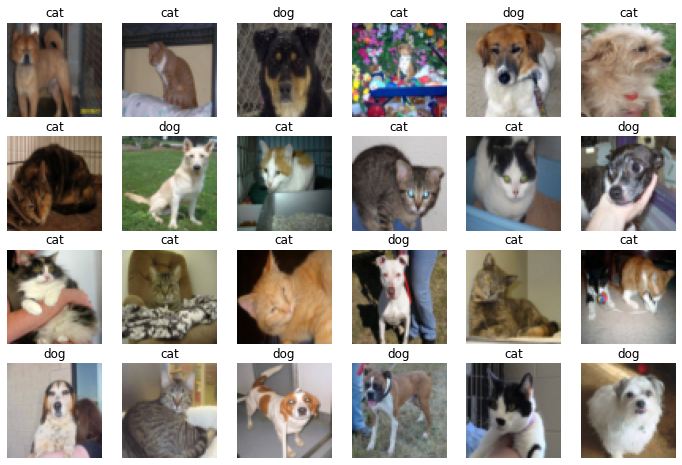

In [26]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))